In [1]:
%matplotlib inline

In [2]:
def nearest_neighbor_mask(x, xc):
    xdist = np.abs(x - xc)
    return np.argsort(xdist)

In [3]:
from rescale_dc2.load_catalogs import load_closest_available_umachine_catalog
umachine_z0 = load_closest_available_umachine_catalog(0.)
umachine_z1 = load_closest_available_umachine_catalog(1.)

In [4]:
import os
dirname = "/Users/aphearin/Dropbox/protoDC2"
sdss_basename = "volume_complete_sdss.hdf5"
protoDC2_basename = "value_added_protoDC2_snapnum_487.hdf5"

from astropy.table import Table
sdss = Table.read(os.path.join(dirname, sdss_basename), path='data')
protoDC2_z0 = Table.read(os.path.join(dirname, protoDC2_basename), path='data')

print(sdss.keys())

['ra', 'dec', 'z', 'bptclass', 'sm', 'sfr', 'specsfr', 'sm_fib', 'sfr_fib', 'specsfr_fib', 'withinr', 'eligiblehost', 'sm_complete', 'eligiblehost2', 'd4000', 'd4000_sub', 'd4000_n', 'd4000_n_sub', 'has_match', 'logM_mendel13', 'logMB_mendel13', 'logMD_mendel13', 'pps_mendel13', 'type_mendel13', 'deltaBD_mendel13', 'dr7_objID', 'has_meert15_match', 'r50_magr_kpc_meert15', 'Magr_tot_meert15', 'Magr_bulge_meert15', 'Magr_disk_meert15', 'gr_bulge_meert15', 'gr_disk_meert15', 'morph_type_T_meert15', 'gr_kcorr_meert15', 'bulge_to_total_rband_meert15', 'logsm_bell03_meert15', 'ssfr']


In [5]:
def compute_log10_ssfr_protoDC2(catalog, quenched_sequence_center=-13.5):
    ssfr = catalog['totalStarFormationRate']/catalog['totalMassStellar']
    zero_mask = ssfr == 0.
    nzeros = np.count_nonzero(zero_mask)
    ssfr[zero_mask] = 10**np.random.normal(loc=quenched_sequence_center, scale=0.2, size=nzeros)
    return np.log10(ssfr)-9.

protoDC2_z0['ssfr'] = compute_log10_ssfr_protoDC2(protoDC2_z0)

In [6]:
from halotools.empirical_models import conditional_abunmatch

protoDC2_z0['remapped_ssfr'] = protoDC2_z0['ssfr']
protoDC2_z0['remapped_ssfr_no_scatter'] = protoDC2_z0['ssfr']

cenmask_um = umachine_z0['upid'] == -1
satmask_um = ~cenmask_um

cenmask_dc2 = protoDC2_z0['isCentral']
satmask_dc2 = ~protoDC2_z0['isCentral']

logsm_bins=np.linspace(9, 12, 40)
for low_sm, high_sm in zip(logsm_bins[:-1], logsm_bins[1:]):
    sm_mask_dc2 = protoDC2_z0['totalMassStellar'] > 10**low_sm
    sm_mask_dc2 *= protoDC2_z0['totalMassStellar'] < 10**high_sm
    num_dc2_sm_bin = np.count_nonzero(sm_mask_dc2)

    cenmask_dc2 = sm_mask_dc2 * (protoDC2_z0['isCentral']==True)
    satmask_dc2 = sm_mask_dc2 * (protoDC2_z0['isCentral']==False)

    mid_sm = 0.5*(low_sm + high_sm)
    idx_censelect = nearest_neighbor_mask(umachine_z0['obs_sm'][cenmask_um], 10**mid_sm)
    idx_satselect = nearest_neighbor_mask(umachine_z0['obs_sm'][satmask_um], 10**mid_sm)
    
    um_ssfr_cens = umachine_z0['obs_ssfr'][cenmask_um][idx_censelect[:1000]]
    ssfr_cens = conditional_abunmatch(protoDC2_z0['ssfr'][cenmask_dc2], um_ssfr_cens)

    um_ssfr_sats = umachine_z0['obs_ssfr'][satmask_um][idx_satselect[:1000]]
    ssfr_sats = conditional_abunmatch(protoDC2_z0['ssfr'][satmask_dc2], um_ssfr_sats, sigma=1)
    ssfr_sats_no_scatter = conditional_abunmatch(protoDC2_z0['ssfr'][satmask_dc2], um_ssfr_sats)

    protoDC2_z0['remapped_ssfr'][cenmask_dc2] = ssfr_cens
    protoDC2_z0['remapped_ssfr_no_scatter'][cenmask_dc2] = ssfr_cens
    protoDC2_z0['remapped_ssfr'][satmask_dc2] = ssfr_sats
    protoDC2_z0['remapped_ssfr_no_scatter'][satmask_dc2] = ssfr_sats_no_scatter
    
    idx_sdss_select = nearest_neighbor_mask(sdss['sm'], mid_sm)
    num_dc2_sm_bin = np.count_nonzero(sm_mask_dc2)
    ssfr_sdss_sample = sdss['ssfr'][idx_sdss_select[:num_dc2_sm_bin]]

    npts_lookup_table = min(num_dc2_sm_bin, 1000)
    protoDC2_z0['remapped_ssfr'][sm_mask_dc2] = conditional_abunmatch(
            np.copy(protoDC2_z0['remapped_ssfr'][sm_mask_dc2]), ssfr_sdss_sample, 
            npts_lookup_table=npts_lookup_table)
    protoDC2_z0['remapped_ssfr_no_scatter'][sm_mask_dc2] = conditional_abunmatch(
            np.copy(protoDC2_z0['remapped_ssfr_no_scatter'][sm_mask_dc2]), ssfr_sdss_sample, 
            npts_lookup_table=npts_lookup_table)

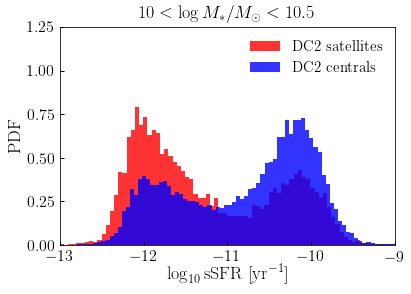

In [7]:
low_sm, high_sm = 10, 10.5
sm_mask = protoDC2_z0['totalMassStellar'] >= 10**low_sm
sm_mask *= protoDC2_z0['totalMassStellar'] < 10**high_sm

sm_mask_cens = sm_mask * (protoDC2_z0['isCentral']==True)
sm_mask_sats = sm_mask * (protoDC2_z0['isCentral']==False)

sm_mask_sdss = sdss['sm'] >= low_sm
sm_mask_sdss *= sdss['sm'] < high_sm

fig, ax = plt.subplots(1, 1)

__=ax.hist(protoDC2_z0['remapped_ssfr'][sm_mask_sats], normed=True, alpha=0.8, bins=100, 
           label=r'${\rm DC2\ satellites}$', color='red')
__=ax.hist(protoDC2_z0['remapped_ssfr'][sm_mask_cens], normed=True, alpha=0.8, bins=100, 
           label=r'${\rm DC2\ centrals}$', color='blue')

xlabel = ax.set_xlabel(r'$\log_{10}{\rm sSFR}\ [{\rm yr}^{-1}]$')
ylabel = ax.set_ylabel(r'${\rm PDF}$')
legend = ax.legend()
xlim = ax.set_xlim(-13., -9)
ylim = ax.set_ylim(0, 1.25)
title = ax.set_title(r'$10 < \log M_{\ast}/M_{\odot} < 10.5$')

figname = 'ssfr_distribution_comparison_sm10p5_cens_sats.pdf'
fig.savefig(figname, bbox_extra_artists=[xlabel, ylabel], bbox_inches='tight')

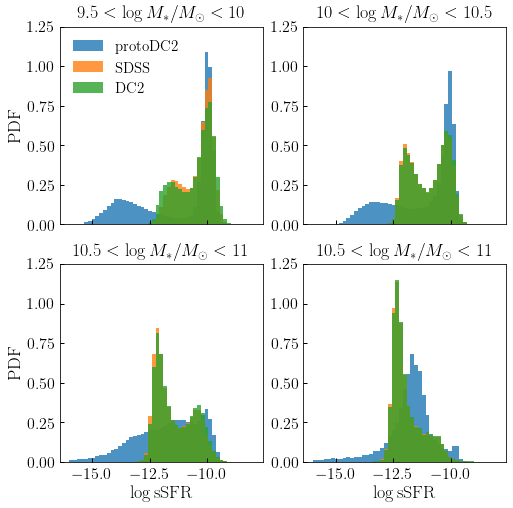

In [20]:
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
(ax1, ax2), (ax3, ax4) = axes

ssfr_bins = np.linspace(-16, -8, 50)


#  Upper-left panel
low_sm, high_sm = 9.5, 10
sm_mask = protoDC2_z0['totalMassStellar'] >= 10**low_sm
sm_mask *= protoDC2_z0['totalMassStellar'] < 10**high_sm
sm_mask_sdss = sdss['sm'] >= low_sm
sm_mask_sdss *= sdss['sm'] < high_sm

__=ax1.hist(protoDC2_z0['ssfr'][sm_mask], normed=True, alpha=0.8, bins=ssfr_bins, 
          label=r'${\rm protoDC2}$')
__=ax1.hist(sdss['ssfr'][sm_mask_sdss], normed=True, alpha=0.8, bins=ssfr_bins, 
          label=r'${\rm SDSS}$')
__=ax1.hist(protoDC2_z0['remapped_ssfr'][sm_mask], normed=True, alpha=0.8, bins=ssfr_bins, 
           label=r'${\rm DC2}$')
title1 = ax1.set_title(r'$9.5 < \log M_{\ast}/M_{\odot} < 10$')
__=ax1.xaxis.set_ticklabels('') 


#  Upper-right panel
low_sm, high_sm = 10, 10.5
sm_mask = protoDC2_z0['totalMassStellar'] >= 10**low_sm
sm_mask *= protoDC2_z0['totalMassStellar'] < 10**high_sm
sm_mask_sdss = sdss['sm'] >= low_sm
sm_mask_sdss *= sdss['sm'] < high_sm

__=ax2.hist(protoDC2_z0['ssfr'][sm_mask], normed=True, alpha=0.8, bins=ssfr_bins, 
          label=r'${\rm Galacticus}$')
__=ax2.hist(sdss['ssfr'][sm_mask_sdss], normed=True, alpha=0.8, bins=ssfr_bins, 
          label=r'${\rm SDSS}$')
__=ax2.hist(protoDC2_z0['remapped_ssfr'][sm_mask], normed=True, alpha=0.8, bins=ssfr_bins, 
           label=r'${\rm DC2}$')
title2 = ax2.set_title(r'$10 < \log M_{\ast}/M_{\odot} < 10.5$')
__=ax2.xaxis.set_ticklabels('') 

#  lower-left panel
low_sm, high_sm = 10.5, 11
sm_mask = protoDC2_z0['totalMassStellar'] >= 10**low_sm
sm_mask *= protoDC2_z0['totalMassStellar'] < 10**high_sm
sm_mask_sdss = sdss['sm'] >= low_sm
sm_mask_sdss *= sdss['sm'] < high_sm

__=ax3.hist(protoDC2_z0['ssfr'][sm_mask], normed=True, alpha=0.8, bins=ssfr_bins, 
          label=r'${\rm Galacticus}$')
__=ax3.hist(sdss['ssfr'][sm_mask_sdss], normed=True, alpha=0.8, bins=ssfr_bins, 
          label=r'${\rm SDSS}$')
__=ax3.hist(protoDC2_z0['remapped_ssfr'][sm_mask], normed=True, alpha=0.8, bins=ssfr_bins, 
           label=r'${\rm DC2}$')
title3 = ax3.set_title(r'$10.5 < \log M_{\ast}/M_{\odot} < 11$')

#  lower-right panel
low_sm, high_sm = 11, 11.5
sm_mask = protoDC2_z0['totalMassStellar'] >= 10**low_sm
sm_mask *= protoDC2_z0['totalMassStellar'] < 10**high_sm
sm_mask_sdss = sdss['sm'] >= low_sm
sm_mask_sdss *= sdss['sm'] < high_sm

__=ax4.hist(protoDC2_z0['ssfr'][sm_mask], normed=True, alpha=0.8, bins=ssfr_bins, 
          label=r'${\rm Galacticus}$')
__=ax4.hist(sdss['ssfr'][sm_mask_sdss], normed=True, alpha=0.8, bins=ssfr_bins, 
          label=r'${\rm SDSS}$')
__=ax4.hist(protoDC2_z0['remapped_ssfr'][sm_mask], normed=True, alpha=0.8, bins=ssfr_bins, 
           label=r'${\rm DC2}$')
title4 = ax4.set_title(r'$10.5 < \log M_{\ast}/M_{\odot} < 11$')

for ax in (ax1, ax2, ax3, ax4):
    ylim = ax.set_ylim(0, 1.25)
    
leg = ax1.legend()

xlabel3 = ax3.set_xlabel(r'$\log {\rm sSFR}$')
xlabel4 = ax4.set_xlabel(r'$\log {\rm sSFR}$')
ylable1 = ax1.set_ylabel(r'${\rm PDF}$')
ylabel3 = ax3.set_ylabel(r'${\rm PDF}$')
    
figname = 'ssfr_distribution_dc2_vs_sdss.pdf'
fig.savefig(figname, bbox_extra_artists=[xlabel3, ylabel3], bbox_inches='tight')

In [9]:
from halotools.mock_observables import tpcf, return_xyz_formatted_array

rbins = np.logspace(-1, 1.5, 25)
rmids = 10**(0.5*(np.log10(rbins[:-1]) + np.log10(rbins[1:])))
low_sm, high_sm = 10, 10.5
sm_mask = protoDC2_z0['totalMassStellar'] >= 10**low_sm
sm_mask *= protoDC2_z0['totalMassStellar'] < 10**high_sm
sm_q_mask = sm_mask * (protoDC2_z0['ssfr'] < -11)
sm_sf_mask = sm_mask * (protoDC2_z0['ssfr'] >= -11)

sm_q_mask2 = sm_mask * (protoDC2_z0['remapped_ssfr'] < -11)
sm_sf_mask2 = sm_mask * (protoDC2_z0['remapped_ssfr'] >= -11)

sm_q_mask3 = sm_mask * (protoDC2_z0['remapped_ssfr_no_scatter'] < -11)
sm_sf_mask3 = sm_mask * (protoDC2_z0['remapped_ssfr_no_scatter'] >= -11)

pos_q = return_xyz_formatted_array(
    protoDC2_z0['x'], protoDC2_z0['y'], protoDC2_z0['z'], mask=sm_q_mask)
pos_sf = return_xyz_formatted_array(
    protoDC2_z0['x'], protoDC2_z0['y'], protoDC2_z0['z'], mask=sm_sf_mask)

pos_q2 = return_xyz_formatted_array(
    protoDC2_z0['x'], protoDC2_z0['y'], protoDC2_z0['z'], mask=sm_q_mask2)
pos_sf2 = return_xyz_formatted_array(
    protoDC2_z0['x'], protoDC2_z0['y'], protoDC2_z0['z'], mask=sm_sf_mask2)

pos_q3 = return_xyz_formatted_array(
    protoDC2_z0['x'], protoDC2_z0['y'], protoDC2_z0['z'], mask=sm_q_mask3)
pos_sf3 = return_xyz_formatted_array(
    protoDC2_z0['x'], protoDC2_z0['y'], protoDC2_z0['z'], mask=sm_sf_mask3)

xi_q = tpcf(pos_q, rbins, period=256.)
xi_sf = tpcf(pos_sf, rbins, period=256.)

xi_q_remapped = tpcf(pos_q2, rbins, period=256.)
xi_sf_remapped = tpcf(pos_sf2, rbins, period=256.)

xi_q_remapped_no_scatter = tpcf(pos_q3, rbins, period=256.)
xi_sf_remapped_no_scatter = tpcf(pos_sf3, rbins, period=256.)


sm_mask = umachine_z0['obs_sm'] >= 10**low_sm
sm_mask *= umachine_z0['obs_sm'] < 10**high_sm
sm_q_mask = sm_mask * (umachine_z0['obs_ssfr'] < -11)
sm_sf_mask = sm_mask * (umachine_z0['obs_ssfr'] >= -11)

pos_q = return_xyz_formatted_array(
    umachine_z0['x'], umachine_z0['y'], umachine_z0['z'], mask=sm_q_mask)
pos_sf = return_xyz_formatted_array(
    umachine_z0['x'], umachine_z0['y'], umachine_z0['z'], mask=sm_sf_mask)

xi_q_um = tpcf(pos_q, rbins, period=250.)
xi_sf_um = tpcf(pos_sf, rbins, period=250.)


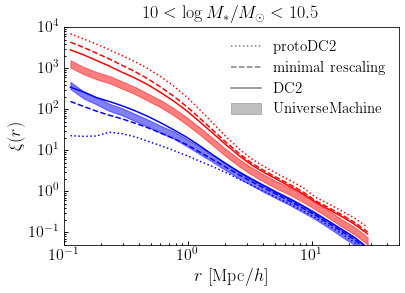

In [19]:
fig, ax = plt.subplots(1, 1)

__=ax.loglog()

__=ax.fill_between(rmids, 0.8*xi_q_um, 1.2*xi_q_um, color='red', alpha=0.5, 
                  label=r'${\rm UniverseMachine}$')
__=ax.fill_between(rmids, 0.8*xi_sf_um, 1.2*xi_sf_um, color='blue', alpha=0.5)


__=ax.plot(rmids, xi_q, ':', color='red', label=r'${\rm protoDC2}$')
__=ax.plot(rmids, xi_q_remapped_no_scatter, '--', color='red', 
           label=r'${\rm minimal\ rescaling}$')
__=ax.plot(rmids, xi_q_remapped, color='red', label=r'${\rm DC2}$')

__=ax.plot(rmids, xi_sf_remapped, color='blue')
__=ax.plot(rmids, xi_sf_remapped_no_scatter, '--', color='blue')
__=ax.plot(rmids, xi_sf, ':', color='blue')

xlim = ax.set_xlim(0.1, 50)
ylim = ax.set_ylim(0.05, 10000)
xlabel = ax.set_xlabel(r'$r\ [{\rm Mpc}/h]$')
ylabel = ax.set_ylabel(r'$\xi(r)$')
title = ax.set_title(r'$10 < \log M_{\ast}/M_{\odot} < 10.5$')

legend = ax.legend()
legend.legendHandles[0].set_color('gray')
legend.legendHandles[1].set_color('gray')
legend.legendHandles[2].set_color('gray')
legend.legendHandles[3].set_color('gray')

figname = 'ssfr_tpcf_dc2_vs_umachine.pdf'
fig.savefig(figname, bbox_extra_artists=[xlabel, ylabel], bbox_inches='tight')

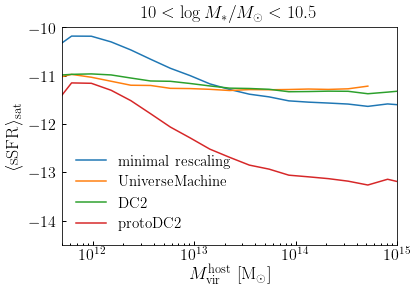

In [18]:
low_sm, high_sm = 10, 10.5

sm_mask_um = umachine_z0['obs_sm'] >= 10**low_sm
sm_mask_um *= umachine_z0['obs_sm'] < 10**high_sm
sm_um_sat_mask = sm_mask_um*(umachine_z0['upid']!=-1)


sm_mask_dc2 = protoDC2_z0['totalMassStellar'] >= 10**low_sm
sm_mask_dc2 *= protoDC2_z0['totalMassStellar'] < 10**high_sm
sm_dc2_sat_mask = sm_mask_dc2*(protoDC2_z0['isCentral']==False)


from scipy.stats import binned_statistic
log_mhost_bins = np.linspace(11.5, 15.2, 20)
mhost_bins = 10**log_mhost_bins
mhost_mids = 10**(0.5*(log_mhost_bins[:-1]+log_mhost_bins[1:]))

mean_ssfr_um, __, __ = binned_statistic(
        umachine_z0['host_halo_mvir'][sm_um_sat_mask], 
    umachine_z0['obs_ssfr'][sm_um_sat_mask], 
        bins=mhost_bins, statistic='mean')

mean_ssfr_galacticus, __, __ = binned_statistic(
        protoDC2_z0['hostHaloMass'][sm_dc2_sat_mask], 
    protoDC2_z0['ssfr'][sm_dc2_sat_mask], 
        bins=mhost_bins, statistic='mean')

mean_ssfr_dc2, __, __ = binned_statistic(
        protoDC2_z0['hostHaloMass'][sm_dc2_sat_mask], 
    protoDC2_z0['remapped_ssfr'][sm_dc2_sat_mask], 
        bins=mhost_bins, statistic='mean')

mean_remapped_ssfr_no_scatter, __, __ = binned_statistic(
        protoDC2_z0['hostHaloMass'][sm_dc2_sat_mask], 
    protoDC2_z0['remapped_ssfr_no_scatter'][sm_dc2_sat_mask], 
        bins=mhost_bins, statistic='mean')

fig, ax = plt.subplots(1, 1)
xscale = ax.set_xscale('log')
__=ax.plot(mhost_mids, mean_remapped_ssfr_no_scatter, label=r'${\rm minimal\ rescaling}$')
__=ax.plot(mhost_mids, mean_ssfr_um, label=r'${\rm UniverseMachine}$')
__=ax.plot(mhost_mids, mean_ssfr_dc2, label=r'${\rm DC2}$')
__=ax.plot(mhost_mids, mean_ssfr_galacticus, label=r'${\rm protoDC2}$')

xlabel = ax.set_xlabel(r'$M_{\rm vir}^{\rm host}\ [{\rm M_{\odot}}]$')
ylabel = ax.set_ylabel(r'$\langle{\rm sSFR}\rangle_{\rm sat}$')
title = ax.set_title(r'$10 < \log M_{\ast}/M_{\odot} < 10.5$')

xlim = ax.set_xlim(5e11, 1e15)
ylim = ax.set_ylim(-14.5, -10)
legend = ax.legend()

figname = 'mean_ssfr_vs_mhalo_dc2_vs_umachine.pdf'
fig.savefig(figname, bbox_extra_artists=[xlabel, ylabel], bbox_inches='tight')